# Example of application of the sdlabb package for metadata extaction
# NCOF method
Created 13-11-20

Author: Fredrik Möller 



# Walkthrough
This walkthrough will only deal with the `NCOF`method available in the package, an example of the `TF-IDF` based method is available in the demos folder. This walkthrough is available as a notebook in the demos folder.
### Install the alpacka package through pip, or download the package through github.

`pip install alpacka`

[Link to github repo](https://github.com/BernhardMoller/alpacka)

### Set up

To be able to use the alpacka package a data set for the analysis is needed. For this walkthrough we will use the Amazon reviews data set, available at (https://jmcauley.ucsd.edu/data/amazon/) 

### Load and preprocess the data 
Before you can pply the alpacka package you will need to load your data and perform preprocessessing/ data cleaning to you likeing. 

For this walkthrough we will load the data using `Pandas` and do some quick preprocessesing using `Keras`. 

In [2]:
import pandas as pd
path_to_data = 'Reviews.csv'
data = pd.read_csv(path_to_data)
nr_samples = 100000
score = data['Score']
text = data['Text']
score = score[0:nr_samples]
text = text[0:nr_samples]

score = score[0:nr_samples]  
score = [elm - 1 for elm in score]

From the code we can see that the data has been loaded and $100,000$ samples has been seperated into the texts and the review score. 

**IMPORTANT:** The translation of the review score is preformed due to the scores have the range of `[1 5]` and alpacka requires all labels to have the range of `[0 n]`. Thus the range is translated from `[1 5]` to `[0 4]`. 

In [3]:
print(text[0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [4]:
print(score[0:10])

[4, 0, 3, 1, 4, 3, 4, 4, 4, 4]


### Preprocess the data
For this walkthrough the data will be preprocessed by passing it though the Tokenizer available in the `Keras`package. This method is not a best practice but good eough for this walkthrough. 


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer(lower = True)  
t.fit_on_texts(text)  
integers = t.texts_to_sequences(text)  
text = t.sequences_to_texts(integers)
print(text[0])

i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most


All the data is now transformed to lowercase and characters such as 
'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' are removed. 

**IMPORTANT:** It is recomended to convert all data to lower or uppercase and remove special characters from the data since alpacka does differentiate between `spam` ,`Spam`, and `spam!`, which can cause skewed results if you interested in the distrubution of `spam` in you data.



### Importing and initiating alpacka
Now we are ready to import and initiate alpacka. 

In [6]:
from alpacka.Pipeline import Pipeline

p = Pipeline()

Now the `NCOF` and `TF-IDF` pipelines are initiated through the wrapper `Pipeline` and the induvidual analysis methods can be accessed be calling:


`p.ncof.some_functions()`

`p.tfidf.some_functions()`

Now we are ready to start the analysis of our data. 

Note that the  `.some_functions()` function is a placeholder and do exist.

### NCOF method:
There are some setting that we can make in the NCOF method that we need to specify before we start. One of which is how many unique tokens do we want to to take into consideration in the analysis, variable `num_words`. The defult setting for this variable is `None` meaning that all unique tokens will be used in the analysis. For "large" data sets this choice is quite ambitious given that the number of tokens that appear only once or twice in the a corpus. 

Another setting that we need to specify is for what class we want the results presented for, variable `class_perspective`. As the NCOF method presents results regarding if a token is overrepresented in a class compared to the rest of the corpus, which class to investigate nees to be specified, the defult value of `class_perspective` is `1`.


In [7]:
p.ncof.set_num_words(10000)
p.ncof.set_class_perspective(0)

For this walkthrough we will limit the analysis to the $10,000$ most common words in the corpus.

#### Calculate NCOF
Now we are ready to calculate the NCOF score for the review data and its scores. This is done by calling the `.calc_ncof(data,labels)` function.  For this example the input in the `data` field is the texts, and the `labels` is the review scores. 

In [8]:
p.ncof.calc_ncof(text, score)

 NCOF score added under 'self.score' use self.get_--- to access the result


We now have an array, `ncof_score`, that contains the NCOF results for our data. This array will have the size `[1,num_words]` and positive and negatives values, indicating if a token is more or less common in investigated class (positives values), or the remaining classes (negative values). The array can be accessed by calling: 


In [9]:
ncof_score = p.ncof.get_score()
print(ncof_score[:10])

[-0.12971953 -0.09604453 -0.07833825 -0.0875291  -0.06695268 -0.06387065
 -0.05505911 -0.04960524 -0.04778746 -0.04113965]


In addition to an array with the scores the `.calc_ncof()` function saves a dictionary that maps the indexes in the  `ncof_score ` array to its text representations, and can be accessed by calling:

In [10]:
dictionary = p.ncof.get_dict()

w = list(dictionary.items())[:10]
for item in w:
    print(item)

(0, 'the')
(1, 'i')
(2, 'and')
(3, 'a')
(4, 'to')
(5, 'it')
(6, 'of')
(7, 'is')
(8, 'br')
(9, 'this')


#### Sorting results
To sort the array into inliers and outliers for the positive and negative values the function `.split_score()`needs to be called. The inliers can be accessed through: 

In [11]:
p.ncof.split_score()

ncof_pos = p.ncof.get_pos_outliers()  
ncof_neg = p.ncof.get_neg_outliers()

 Inliers added under 'self.inliers' 
 Positive outliers added under 'self.pos_outliers' 
 Negative outliers added under 'self.neg_outliers' 
 use self.get_--- to access the result


Which will return the indexes of the words in the dictionary that are considered as outliers in the NCOF results.

The results are sorted within the `ncof_pos `and `ncof_neg ` as the following:

ncof_pos[0] = $\mu+\sigma\leq result <\mu+2\sigma$
   
ncof_pos[1] = $\mu+2\sigma\leq result <\mu+3\sigma$
   
ncof_pos[2] = $\mu+3\sigma\leq result$
   
   
ncof_neg[0] = $\mu-\sigma\geq result >\mu-2\sigma$
   
ncof_neg[1] = $\mu-2\sigma\geq result >\mu-3\sigma$

ncof_neg[2] = $\mu-3\sigma\geq result$

#### Plotting results
These results can be plotted by calling the function `.scatter()` which will give visual information regarding what tokens are over or under represented in the investigated class. 

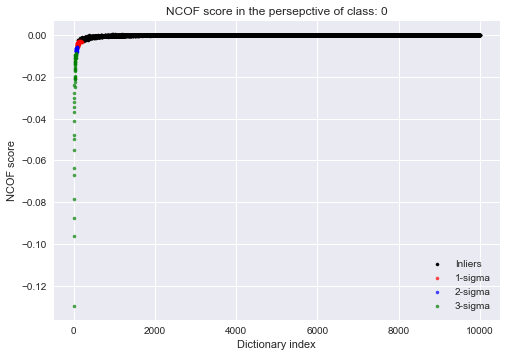

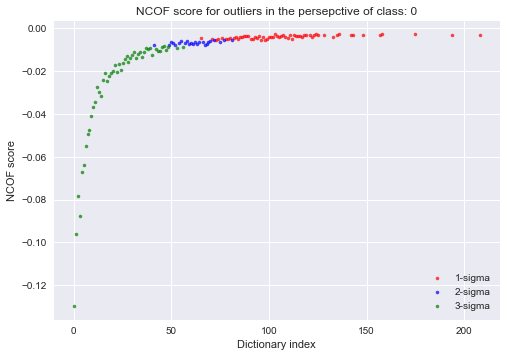

In [12]:
p.ncof.scatter()

#### Converting results from indexes to text
Since it is quite difficult to interpret the socre for each the indexes directly, it is suggested that the indexes are transformed back to their text representations. This can be done by calling the `.ncof.ind_2_txt(data)`function, the function input should be either indexes of the positive or negative outlers. 

In [13]:
words_pos = p.ncof.ind_2_txt(ncof_pos)

words_neg = p.ncof.ind_2_txt(ncof_neg)

If the text results want to be cleaned from stop words for clarification. The function `.remove_stop_words(data,stop_words)` can be called. This functon compares the content of the input `data` to that of the input `stop-words` and removes any matches between them from the `data`. For this walkthrough we will use the stop words available from the NLTK package.

In [14]:
import nltk  
from nltk.corpus import stopwords  
nltk.download('stopwords')  
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Fredrik
[nltk_data]     Möller\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now stop words can be removed from our results.

In [15]:
words_pos = p.ncof.remove_stop_words(words_pos,stop_words)
    
words_neg = p.ncof.remove_stop_words(words_neg,stop_words)

#### Print results to terminal. 
We have now gone through all the steps required to produce, plot, and clean the reults from the NCOF analysis method. The last part is to either save the results to a file or to print them to the terminal. Since format to save the results to is a user preference no function for this is provided in the alpacka package, however the results can be printed to the terminal by calling the following function.

The input variable `sort` can be set to either `True` or `False` and decides if the results should be printed as alphabetically sorted or not. 
   

In [16]:
print(f"printing outliers from the investigated class")
p.ncof.print_outliers_to_terminal(words_pos, sort = True)
print(f" ")
print(f"printing outliers from the remaining classes")
p.ncof.print_outliers_to_terminal(words_neg, sort = True)

printing outliers from the investigated class
Printing 1-sigma outliers, alphabetically sorted
####################
####################
Printing 2-sigma outliers, alphabetically sorted
####################
####################
Printing 3-sigma outliers, alphabetically sorted
####################
####################
 
printing outliers from the remaining classes
Printing 1-sigma outliers, alphabetically sorted
####################
1
2
3
also
amazon
bag
best
better
bit
box
buy
chocolate
cup
dog
drink
eat
even
find
first
found
give
however
i'm
i've
make
nice
price
something
still
sugar
sweet
think
though
time
tried
try
two
use
used
water
way
well
####################
Printing 2-sigma outliers, alphabetically sorted
####################
food
get
little
love
much
really
####################
Printing 3-sigma outliers, alphabetically sorted
####################
br
coffee
flavor
good
great
like
one
product
taste
tea
would
####################
